# Hydrogen Atom Demo

We'll explore some of the interesting physics of the hydrogen atom today. We'll start by first, exploring some of the basic properties of the hydrogenic wave by plotting them and then computing the average position as a function of principle quantum number. From there, we'll go ahead and create energy level diagrams and spectrograms.

Before we start, run the cell below.

## <i class="fa fa-book"></i> Step 1:  Modules, Preliminaries

In [1]:
from scipy.misc import factorial
from scipy.special import genlaguerre, binom, eval_genlaguerre
from scipy.integrate import simps, quad

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import os
import sys
sys.path.append('../library')
sys.path.append('../../library')
sys.path.append('/home/student/chem160/library')
#This is how we'll import our own home-made modules
import quantumWorld as qworld

##  Some functions

Don't worry to much about them..we will use them as blackbox methos...a summary:

* **EnergyTuple** is a data strcuture to hold quantum number and their energy values
* **energy_diagram_plotter**, is a special plotting function that make bars for eahc energy level and display their quantum numbers
* **L(rho, alpha, n)**, returns generalized laguerre polynomial with subscript n, and parameters rho and alpha

In [2]:
# This class allows us to do various energy manipulations.
#It's not really important to know how it works, just use it as a black box
class EnergyTuple:
    def __init__(self, name=None, energy=1.0, quantumNumbers=[],  efunc = None, **kwds):
        '''
        Init function. You should almost certainly pass in the quantum numbers dictionary and energy function to actually
        get any use
        '''
        self.energy=energy # sets energy to default value
        self.qn = quantumNumbers # sets quantum number dictionary, qn, to what was passed in
        if name != None: # sets name of the state to the given one, if one is passed in
            self.name=name
        else: # Other wise, name the state according to the the quantum numbers passed in
            string = ""
            for key in self.qn:
                string += key + " = " + str(self.qn[key]) + ", "
            self.name = string[:-2] # Trim off the last comma
        if efunc != None: # Sets the energy to the proper value, if the energy function was defined
            self.efunc = efunc
            self.populateEnergy()
        else:
            self.energy = 1.0
        self.__dict__.update(kwds)
    
    def populateEnergy(self):
        # Sets the energy
        self.energy = self.efunc(self.qn)
    
    def energyInWavenumbers(self):
        # Returns the energy converted from hartrees to wavenumbers [cm^-1]
        return self.energy*2.1947e5
    
    def wavelength(self):
        # Returns the wavelength associated with the energy
        return np.abs(45.56*1.0/self.energy)
    
    def colour(self, n1=2.0):
        # Returns the colour. Don't worry about this, it's just interpolation stuff.
        w = self.wavelength()
        # colour
        if w >= 380 and w < 440:
            R = -(w - 440.) / (440. - 350.)
            G = 0.0
            B = 1.0
        elif w >= 440 and w < 490:
            R = 0.0
            G = (w - 440.) / (490. - 440.)
            B = 1.0
        elif w >= 490 and w < 510:
            R = 0.0
            G = 1.0
            B = -(w - 510.) / (510. - 490.)
        elif w >= 510 and w < 580:
            R = (w - 510.) / (580. - 510.)
            G = 1.0
            B = 0.0
        elif w >= 580 and w < 645:
            R = 1.0
            G = -(w - 645.) / (645. - 580.)
            B = 0.0
        elif w >= 645 and w <= 780:
            R = 1.0
            G = 0.0
            B = 0.0
        else:
            R = 0.0
            G = 0.0
            B = 0.0

        # intensity correction
        if w >= 380 and w < 420:
            SSS = 0.3 + 0.7*(w - 350) / (420 - 350)
        elif w >= 420 and w <= 700:
            SSS = 1.0
        elif w > 700 and w <= 780:
            SSS = 0.3 + 0.7*(780 - w) / (780 - 700)
        else:
            SSS = 0.0
        SSS *= 255

        return (int(SSS*R), int(SSS*G), int(SSS*B))
    
    
def energy_diagram_plotter(energy_list):
    linewidth = 200.0
    offset_to_add = 240.0
    fig = plt.figure( figsize=(14, 3))
    ax = fig.add_subplot(111)
    plt.xlim([-linewidth/2.0-5.0, 2000.0])
    plt.ylim([-0.6, 0.0])

    eprev = 0.0
    offset = 0.0
    for et in energyList:
        if eprev == et.energy:
            offset += offset_to_add
        else:
            offset = 0.0    
        xmin = -linewidth/2.0+offset
        xmax =  linewidth/2.0+offset
        y = et.energy
        plt.hlines(y, xmin, xmax, linewidth=2)
        ax.annotate(et.name, xy=(xmin, y-0.013))
        fig.set_size_inches(18.5,10.5)
        eprev = et.energy
    return 
    
def L(rho, alpha, n):
    '''
    This method returns the generalized laguerre polynomial with subscript n
    # and superscript alpha for points rho
    This is a giant pain to get all the factors just right. Don't do it.
    
    INPUT
    --------------------
    rho: Array of points to return the value of the polynomial on
    alpha: Superscript parameter
    n: Subscript parameter
    
    OUTPUT
    --------------------
    poly: Array with the discrete values of the specified Laguerre polynomial
    '''
    poly = np.zeros_like(rho)
    for i in range(0, int(n)+1):
        coeff = binom(n+alpha, n-i)*(-1)**i/(factorial(i))
        poly += coeff*np.power(rho, i)
    return poly

## Step 2 : <i class="fa fa-wrench"></i>  Radial wavefunction
Go ahead and fill in the radial wavefunction function below. Remember that the radial piece, $R_{nl}(r)$, is given by
$$R_{nl}(r) = N \mathcal{L}^{2l+1}_{n-1-1}(\rho)\rho^l e^{-\rho/2} $$
where $N$ is the normalization constant, $\mathcal{L}^{2l+1}_{n-1-1}(\rho)$ is the generalized Laguerre polynomial, and $\rho$ is the atomic radius when corrected for principle quantum number and nuclear charge. Note, I have already defined the normalization constant as normFactor.

In [3]:
def hydrogen_radial_wf(r, n, l, a0=1.0, z=1.0):
    '''
    This method will return the radial part of the wave function. I've gone ahead and defined the normalization factor but you
    will need to implement the rest.
    
    INPUT
    --------------------
    r: Array of points to return the value of the wavefunction on
    n: principle quantum number
    l: angular quantum number
    
    OUTPUT
    --------------------
    wf: Array of points to return the wavefunction
    '''
    rho = 2.0*z*r/(n*a0)
    subscript = n-l-1.0
    superscript = 2.0*l+1.0
    normFactor = np.sqrt((2.0*z/(n*a0))**3*factorial(subscript)/(2.0*n*factorial(n+l)))
    
    # Fill this line in
    wf=rho**l*np.exp(-rho/2.0)*eval_genlaguerre(subscript,superscript,rho)
    return wf*normFactor

### <i class="fa fa-line-chart"></i> Let's plot the radial functions!
With the function defined above, let's go ahead and plot to compare!

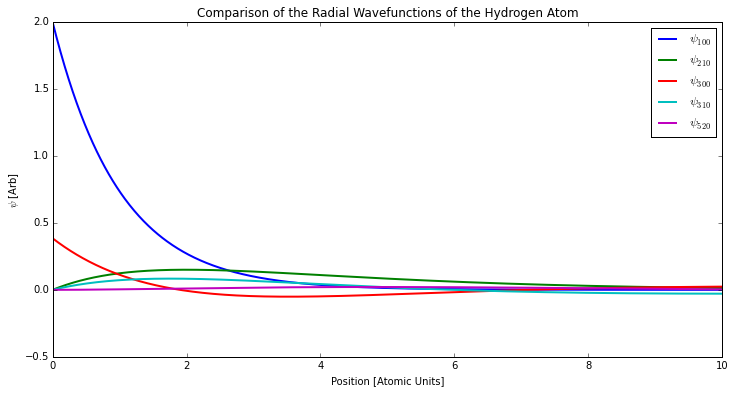

In [4]:
r=np.arange(0.0, 30.0, 0.01)

plt.figure( figsize=(12, 6))
plt.plot(r,hydrogen_radial_wf(r, 1, 0),label='$\psi_{100}$',lw=2)
plt.plot(r,hydrogen_radial_wf(r, 2, 1),label='$\psi_{210}$',lw=2)
plt.plot(r,hydrogen_radial_wf(r, 3, 0),label='$\psi_{300}$',lw=2)
plt.plot(r,hydrogen_radial_wf(r, 3, 1),label='$\psi_{310}$',lw=2)
plt.plot(r,hydrogen_radial_wf(r, 5, 2),label='$\psi_{520}$',lw=2)


plt.title('Comparison of the Radial Wavefunctions of the Hydrogen Atom')
plt.xlabel('Position [Atomic Units]')
plt.ylabel('$\psi$ [Arb]')
plt.xlim([0,10])
plt.legend()
plt.show()

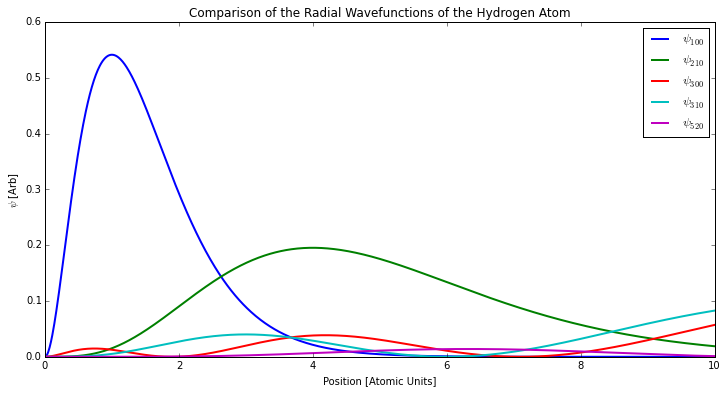

In [11]:
r=np.arange(0.0, 30.0, 0.01)

plt.figure( figsize=(12, 6))
plt.plot(r,np.abs(r*hydrogen_radial_wf(r, 1, 0))**2,label='$\psi_{100}$',lw=2)
plt.plot(r,np.abs(r*hydrogen_radial_wf(r, 2, 1))**2,label='$\psi_{210}$',lw=2)
plt.plot(r,np.abs(r*hydrogen_radial_wf(r, 3, 0))**2,label='$\psi_{300}$',lw=2)
plt.plot(r,np.abs(r*hydrogen_radial_wf(r, 3, 1))**2,label='$\psi_{310}$',lw=2)
plt.plot(r,np.abs(r*hydrogen_radial_wf(r, 5, 2))**2,label='$\psi_{520}$',lw=2)


plt.title('Comparison of the Radial Wavefunctions of the Hydrogen Atom')
plt.xlabel('Position [Atomic Units]')
plt.ylabel('$\psi$ [Arb]')
plt.xlim([0,10])
plt.legend()
plt.show()


### <i class="fa fa-wrench"></i>  Radial expectection values
Next, let's go ahead and compute the radial expectation value. Go ahead and fill in the function called r_expectation. Run the cell with that in hand. What do you see?

n = 1 	 l = 0 	 <r> = 1.50	 error = 1.404e-09
n = 2 	 l = 0 	 <r> = 6.00	 error = 4.837e-08
n = 3 	 l = 0 	 <r> = 13.50	 error = 9.361e-08
n = 4 	 l = 0 	 <r> = 24.00	 error = 1.579e-07
n = 5 	 l = 0 	 <r> = 37.50	 error = 8.357e-08
n = 6 	 l = 0 	 <r> = 54.00	 error = 1.339e-07
n = 7 	 l = 0 	 <r> = 73.50	 error = 4.726e-07
n = 8 	 l = 0 	 <r> = 96.00	 error = 5.258e-07
n = 9 	 l = 0 	 <r> = 121.50	 error = 9.271e-08
n = 10 	 l = 0 	 <r> = 150.00	 error = 1.008e-06
n = 11 	 l = 0 	 <r> = 181.50	 error = 3.462e-07
n = 12 	 l = 0 	 <r> = 216.00	 error = 1.019e-06
n = 13 	 l = 0 	 <r> = 253.50	 error = 4.62e-07
n = 14 	 l = 0 	 <r> = 294.00	 error = 1.096e-07
n = 15 	 l = 0 	 <r> = 337.50	 error = 2.376e-06
n = 16 	 l = 0 	 <r> = 384.00	 error = 1.795e-06
n = 17 	 l = 0 	 <r> = 433.50	 error = 4.524e-06
n = 18 	 l = 0 	 <r> = 486.00	 error = 4.839e-06
n = 19 	 l = 0 	 <r> = 541.50	 error = 3.821e-06


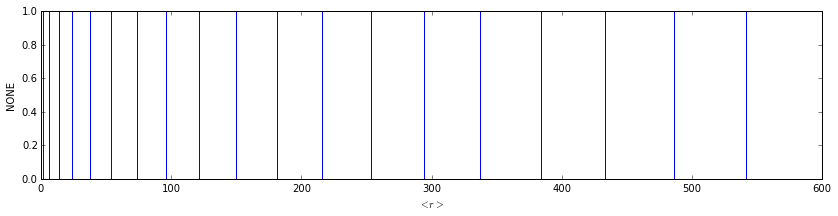

In [38]:
def r_expectation(r, n, l, a0=1.0, z=1.0):
    '''
    This method will return the integrand for the radial expectation value
    
    INPUT
    --------------------
    r: Scalar or array of points to return the value of the wavefunction on
    n: principle quantum number
    l: angular quantum number
    
    OUTPUT
    --------------------
    The value of the overlap integrand
    '''
    ## Two lines, get the radial wavefunction
    wf=hydrogen_radial_wf(r, n, l, a0=1.0, z=1.0)
    r_expectation= np.conjugate(wf)*r**3.0*wf
    return r_expectation
    

nstates = 20
r_exp = np.zeros((nstates, ))
plt.figure(1, figsize=(14, 3))
for i in range(1, nstates):
    radial_wf = hydrogen_radial_wf(r, i, 0)
    r_exp[i], error = quad(r_expectation, 0, np.inf, args=(i, 0))
    plt.axvline(r_exp[i])
    print("n = %d \t l = 0 \t <r> = %3.2f\t error = %2.4g"%(i,r_exp[i],error))

plt.xlabel('$ < r >  $')
plt.ylabel('NONE')
plt.show()

## Step 3: <i class="fa fa-wrench"></i> Wavefuntion energy values
Next, let's fill in a function to compute the energy of a specific energy level.

$$ E_n = \frac{-\mu c^2 Z^2 \alpha^2}{2} \frac{1}{n^2}$$

Note, we're passing in qn as a dictionary. This means that each element has a key and a value pair. To access a specific value associated with a specific key, you simply pass in the key of interest. For example, if we want the n quantum number from the qn dictionary, we would do: qn['n']

### <i class="fa fa-wrench"></i> Complete the function

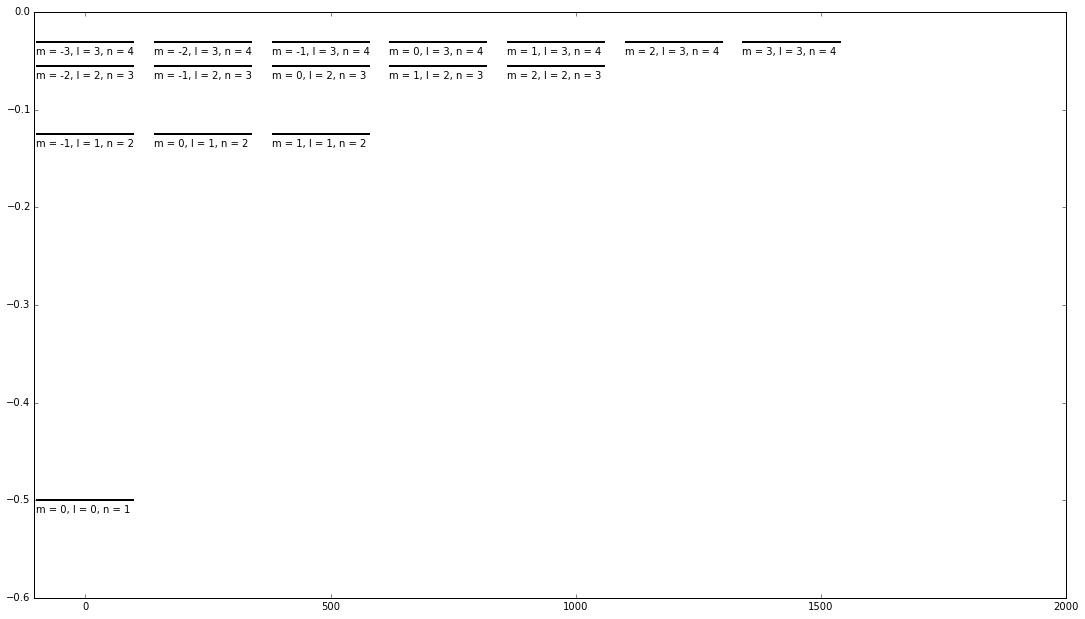

In [39]:
def hydrogen_energy(qn, a0 = 1.0, Z=1.0, mu = 1.0, c = 137.0, alpha = 1.0/137.0):
    '''
    Function to return the ionization energy for a specific state, specified by qn.
    INPUT
    ---------------------
    qn: Dictionary of quantum numbers. It should have three keys (n, l, m),
    that are accessible via qn['n'], qn['l'], qn['m']
    
    OUTPUT
    ---------------------
    Energy in hartrees. We'll convert the energies later as necessary.
    '''
    # Translate the formula above into an energy and then return it
    # ONE or at most TWO lines 
    En = -(mu*c**2*alpha**2)/2.0 * (1.0/qn['n']**2)
    return En

# ===========================================================================================
energyList = [] # Defines a list that we will populate with energy tuple objects
for n in range(1, 5): # Loops through the principle quantum numbers from 1 to 4
    l = n-1 # Defines l such that we get maximum multipliity
    for m in range(-l, l+1): # Loops through m, ranging from -l to l
        # below we append an element to the list. 
        # To create an object, we need tell it what the associated
        # quantum numbers are, as well as how to compute the energies.
        # We'll want to use the hydrogen energy
        # levels for this, but we can pass it any energy function we'd like.
        # It might be an interesting
        # exercise to explore the energy level diagram of
        # different systems like the harmonic oscillator
        # or the hydrogen atom in a magnetic field
        qdict ={"n":n, "l":l, "m":m}
        energyList.append(EnergyTuple(quantumNumbers=qdict, efunc = hydrogen_energy))
        
# Creates the diagram. Notice the multiplicity and degeneracy. 
energy_diagram_plotter(energyList)


## Step 4: Transition energies

Next, let's fill in a function to compute the transition energy from one energy level to another.

$$ E_{n_1 \rightarrow n_2} = \frac{-\mu c^2 Z^2 \alpha^2}{2} \left(\frac{1}{n_1^2} - \frac{1}{n_2^2} \right)$$

Note, we're passing in qn as a dictionary. This means that each element has a key and a value pair. To access a specific value associated with a specific key, you simply pass in the key of interest. For example, if we want the n1 quantum number from the qn dictionary, we would do: qn['n1']

### <i class="fa fa-wrench"></i> Complete the function

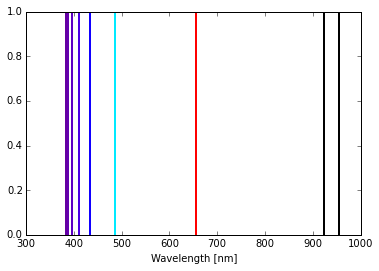

In [42]:
def hydrogen_transition_energy(qn, a0 = 1.0, Z=1.0, mu = 1.0, c = 137.0, alpha = 1.0/137.0):
    '''
    Function to return the ionization energy for a specific state, specified by qn.
    INPUT
    ---------------------
    qn: Dictionary of quantum numbers.
        It should have six keys (n1, l1, m1, n2, l2, m2), 
        that are accessible via qn['n1'], qn['l1'], qn['m1'], etc
    
    OUTPUT
    ---------------------
    Energy in hartrees. We'll convert the energies later as necessary.
    '''
    # Translate the formula above into an energy and then return it
    # ONE or TWO lines 
    En = -(mu* (c**2) * (Z**2) * (alpha**2) )/2.0 * (1.0/qn['n1']**2 - 1.0/qn['n2']**2)
    return En

# =========================================================================================================
# Defines a list that we will populate with energy tuple objects
energyListSpectrogram = [] 
# Loops through the initial principle quantum numbers from 1 to 9
for n1 in range(1, 10): 
    # Loops through the final principle quantum numbers from 1 to 9
    for n2 in range(1, 10): 
        if n1 != n2: # Ensures that a transition actually happens
            # below we append an element to the list.
            # To create an object, we need tell it what the associated
            # quantum numbers are, as well as how to compute the energies. 
            # We'll want to use the hydrogen transition energyies.
            # Note, I've gone ahead and defined the quantumNumbers 
            # dictionary for you, already.
            qdict = {"n1":n1, "l1":0, "m1":0, "n2":n2, "l2":0, "m2":0}
            energyListSpectrogram.append(EnergyTuple(quantumNumbers=qdict, 
                                         efunc=hydrogen_transition_energy))
for et in energyListSpectrogram:
    # Places a vertical line at the position of the transition with the colour of the transition. 
    # Note that the colour logic ('#%02x%02x%02x'%et.colour()) converts rgb to hex numbers
    plt.axvline(et.wavelength(), color='#%02x%02x%02x'%et.colour(),lw=2)
    plt.xlabel('Wavelength [nm]')
    plt.xlim([300, 1000])

## <i class="fa fa-flask"></i> How does it compare experimentally?

![](files/Hydrogen_spectra.jpg)